# Data exploration

In [1]:
import datasets

dataset = datasets.load_dataset('eve-esa/eve-cpt-sample-v0.2')['train']

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def sample_dataset(dataset: datasets.Dataset, num_bins: int, n_samples: int = 1000):
    """
    Sample the dataset accordingly to the distribution of the lengths of the examples.
    :param dataset: 
    :param num_bins: 
    :param n_samples: 
    :return: 
    """
    lengths = np.array([get_length(example) for example in dataset])
    hist, bin_edges = np.histogram(lengths, bins=num_bins, density=True)

    # Assign each example to a bin
    bin_indices = np.digitize(lengths, bins=bin_edges, right=True)
    
    # Sample from each bin proportionally
    sampled_indices = []
    for i in range(1, num_bins + 1):
        bin_members = np.where(bin_indices == i)[0]
        if len(bin_members) > 0:
            num_samples = int(n_samples * len(bin_members) / len(lengths))
            sampled_indices.extend(np.random.choice(bin_members, size=num_samples, replace=False).tolist())
    
    
    if len(sampled_indices) > n_samples:
        # Ensure exactly 1000 samples
        sampled_indices = np.random.choice(sampled_indices, size=n_samples, replace=False)
        
    return dataset.select(sampled_indices)


# Load dataset (replace with your dataset)

# Define a function to compute length of each example
def get_length(example):
    return len(example["text"].split())  # Change to len(example["text"]) for character length

def plot_lengths(dataset, num_bins=50):
    # Compute lengths
    lengths = np.array([get_length(example) for example in dataset])
    
    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=num_bins, alpha=0.75, color='blue', edgecolor='black')
    plt.xlabel("Number of Words")
    plt.ylabel("Frequency")
    plt.title("Dataset Length Distribution")
    plt.grid(True)
    plt.show()

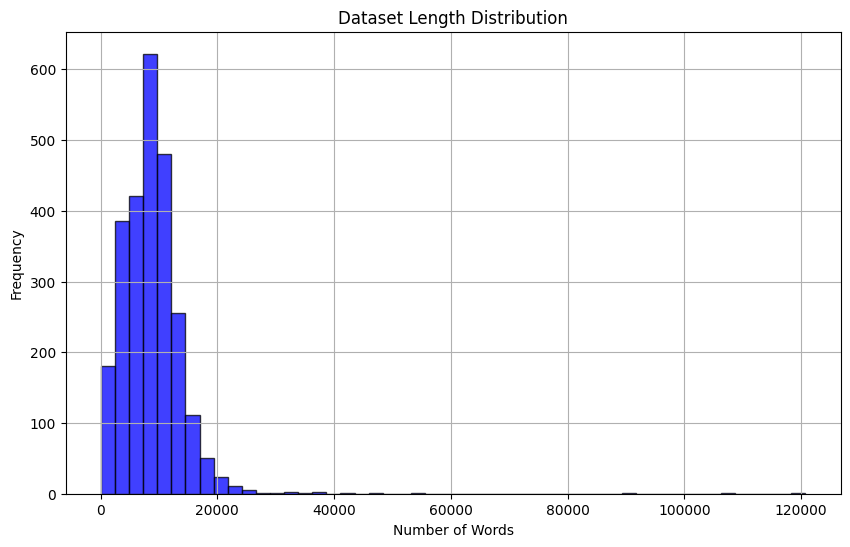

In [3]:
plot_lengths(dataset)

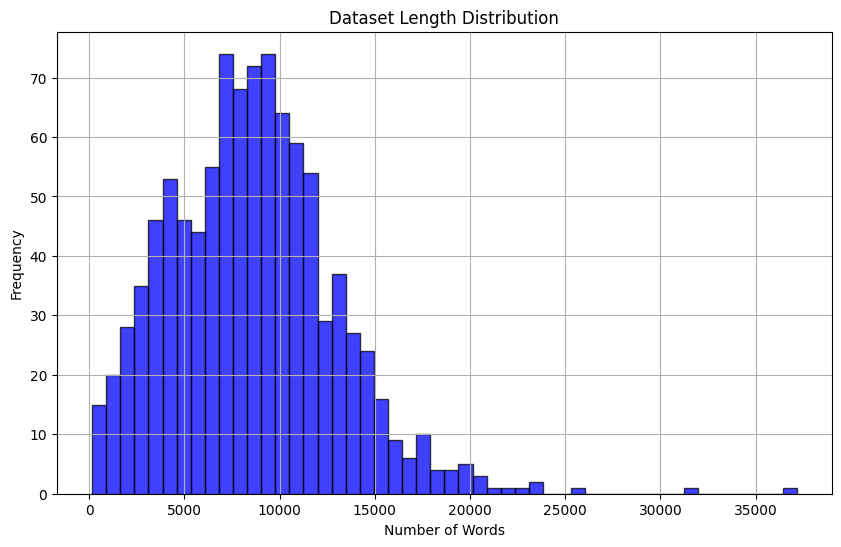

In [4]:
sampled_dataset = sample_dataset(dataset, num_bins=50, n_samples=1000)
plot_lengths(sampled_dataset)

In [12]:
# Extract and remove abstarct from the dataset
import re

def extract_abstract(sample):
    # Regex to extract the abstract
    abstract_pattern = re.compile(r"#{0,6}(\s|.)Abstract\s*\n\n(.*?)(_Keywords.*?|#{0,6}\s*.*Introduction)", re.S | re.I)
    #abstract_pattern = re.compile(r"(#|\*){0,6}\s*Abstract.*\n\n(.*?)(#{0,6}\s*.*Introduction)", re.S | re.I)
    text = sample['text']
    # Extract abstract
    match = abstract_pattern.search(text)
    if match:
        abstract = match.group(1).strip()
    else:
        # Interrupt the abstract to the new paragraph
        abstract_pattern = re.compile(r"(#|\*){0,6}\s*Abstract.*\n\n(.*?)\n\n", re.S)
        match = abstract_pattern.search(text)
        if match:
            abstract = match.group(1).strip()
        else:
            abstract = None

    # Remove abstract from text
    text_without_abstract = abstract_pattern.sub("", text).strip()
    return {'text': text_without_abstract, 'abstract': abstract}


def remove_after_conclusions(text):
    """
    Removes everything after the conclusions section.
    Detects a heading containing 'conclusion' and captures its content
    until the next section heading.
    """
    # Regex pattern to match a heading containing "conclusion"
    conclusion_pattern = re.compile(r"(\n\s*#{1,6}\s*.*conclusion.*\n)(.*?)(?=\n\s*#{1,6}\s*\w+)", re.I | re.S)

    # Search for the conclusion section
    match = conclusion_pattern.search(text)
    if match:
        after_conclusion = text[match.end():]
        text = text[:match.end()].strip()  # Keep everything up to the end of the conclusion section
    else:
        after_conclusion = None
    
    return text, after_conclusion


def remove_references(text):
    """
    Removes the references section.
    Detects a heading containing 'references' and captures its content
    until the end of the text.
    """
    # Regex pattern to match a heading containing "references"
    references_pattern = re.compile(r"(\n\s*#{1,6}\s*references\s*\n)(.*$)", re.I | re.S)

    # Search for the references section
    match = references_pattern.search(text)
    if match:
        text = text[:match.start()].strip()  # Keep everything up to the start of the references section
    
    return text


def remove_acknowledgements(text):
    """
    Removes the acknowledgements section.
    Detects a heading containing 'acknowledgements' and captures its content
    until the next section heading.
    """
    # Regex pattern to match a heading containing "acknowledgements"
    acknowledgements_pattern = re.compile(r"(\n\s*#{1,6}\s*acknowledgements\s*\n)(.*?)(?=\n\s*#{1,6}\s*\w+)", re.I | re.S)

    # Search for the acknowledgements section
    match = acknowledgements_pattern.search(text)
    if match:
        text = text[:match.start()].strip()  # Keep everything up to the start of the acknowledgements section
    
    return text


def extract_headings(text):
    """
    Extracts the headings from the text.
    """
    # Regex pattern to match headings
    heading_pattern = re.compile(r"(#{1,6})\s*(.*?)\s*(?:\n|$)")

    # Find all headings
    headings = heading_pattern.findall(text)
    # Keep only the heading text
    headings = [heading[1] for heading in headings]
    return headings


In [102]:
import pandas as pd

# Convert to pandas
data_pd = dataset.to_pandas()

# Extract headings
data_pd['headings'] = data_pd['text'].apply(extract_headings)
data_pd

,article_title,text,headings
0,0505068v5,# Stochastic inequalities for single-server lo...,[Stochastic inequalities for single-server los...
1,1004.1789v1,# SAR Image Segmentation using Vector Quantiza...,[SAR Image Segmentation using Vector Quantizat...
2,1106.1617v1,# Migration of Gas Giant Planets in Gravitatio...,[Migration of Gas Giant Planets in Gravitation...
3,1207.4754v1,# Scaling mechanism for efficient wavelength c...,[Scaling mechanism for efficient wavelength co...
4,1204.3030v1,# One possible mechanism for massive neutron s...,[One possible mechanism for massive neutron st...
...,...,...,...
2555,mdpi_volume_10_issue_10_article_7,Upscaling Solar-Induced Chlorophyll Fluorescen...,"[Abstract, 1 Introduction, Materials and Metho..."
2556,mdpi_volume_10_issue_12_article_93,Mapping Root-Zone Soil Moisture Using a Temper...,"[Abstract, 1 Introduction, 2 Study Site, Metho..."
2557,mdpi_volume_10_issue_10_article_125,Landslide Susceptibility Mapping and Compariso...,"[Abstract, 1 Introduction, 2 Data and Pre-Proc..."
2558,mdpi_volume_10_issue_11_article_181,Evaluation of Sensor and Environmental Factors...,"[Abstract, 2 Materials and Methods, Forest Can..."


In [14]:
from tqdm.notebook import tqdm
import pandas as pd
tqdm.pandas()
# Convert to pandas
#data_w_abstract = sampled_dataset.to_pandas()
#data_w_abstract[['text', 'abstract']] = data_w_abstract['text'].progress_apply(lambda x: pd.Series(extract_abstract(x)))
#[['text', 'after_conclusion']] = data_w_abstract['text'].apply(lambda x: pd.Series(remove_after_conclusions(x)))
#data_w_abstract['text'] = data_w_abstract['text'].apply(remove_references)
#data_w_abstract['text'] = data_w_abstract['text'].apply(remove_acknowledgements)

sampled_dataset.map(extract_abstract)

Map:   0%|          | 0/989 [00:00<?, ? examples/s]

KeyboardInterrupt: 

In [112]:
dataset[255]['article_title']

'1006.0926v1'

In [ ]:
# Select NaN in the abstract column
data_w_abstract[data_w_abstract['abstract'].isna()]

In [126]:
sample_n = 38
print(dataset[sample_n]['text']) 
print('------------------------------')
print(data_w_abstract['text'][sample_n])

# Variability of North Atlantic hurricanes: seasonal versus individual-event features

**Abstract.** Tropical cyclones are affected by a large number of climatic factors, which translates into complex patterns of occurrence. The variability of annual metrics of tropical-cyclone activity has been intensively studied, in particular since the sudden activation of the North Atlantic in the mid 1990's. We provide first a swift overview on previous work by diverse authors about these annual metrics for the North-Atlantic basin, where the natural variability of the phenomenon, the existence of trends, the drawbacks of the records, and the influence of global warming have been the subject of interesting debates.

Next, we present an alternative approach that does not focus on seasonal features but on the characteristics of single events [Corral et al., _Nature Phys._ 6, 693 (2010)]. It is argued that the individual-storm power dissipation index (PDI) constitutes a natural way to describe each 